<a href="https://colab.research.google.com/github/thiago-abarros/twitter-sentiment-analysis/blob/main/notebooks/twitter-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Importando Bibliotecas

A seguir, vamos importar as bibliotecas necessárias para o processamento de texto, construção de modelo de Machine Learning e visualização de dados.

In [60]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from keras.src.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Flatten
from keras.utils import to_categorical
import time
import warnings

warnings.filterwarnings("ignore")

# 2. **Carregamento e Análise Inicial dos Dados**
- **Dataset**: Arquivo CSV contendo tweets categorizados como positivos, negativos ou neutros.
- **Verificações**:
  - Exibição de amostras do dataset.
  - Checagem e contagem de valores nulos.
  - Estatísticas de distribuição das categorias (`positive`, `neutral`, `negative`).

In [61]:
import numpy as np
import pandas as pd

df = pd.read_csv("data/Twitter_Data.csv")
df.sample(5)

,clean_text,category
155007,\ntoday every indian saying modi standing firm...,-1.0
114663,never stopped teasing middle class not necessa...,-1.0
115985,modi plays all games like this wins ever,1.0
94450,mock modi moremore you better gets,1.0
131093,means others are tainted except modi but this ...,0.0


In [62]:
df.isnull().sum()

,0
clean_text,4
category,7


In [63]:
def count_values_in_column(data, feature):
    total = data.loc[:, feature].value_counts(dropna=False)
    percentage = round(
        data.loc[:, feature].value_counts(dropna=False, normalize=True) * 100, 2
    )
    return pd.concat([total, percentage], axis=1, keys=["Total", "Percentage"])


count_values_in_column(df, "category")

,Total,Percentage
category,,
1.0,72250,44.33
0.0,55213,33.88
-1.0,35510,21.79
NaN,7,0.00


## Deduções iniciais
- Nessa base de dados, temos mais que 40% de tweets positivos
- Os tweets negativos estão em menor quantidade, com apenas 50% do total em comparação com os tweets positivos
- Os tweets neutros têm uma quantidade considerável, ficando entre o total de tweets positivos e negativos.

In [64]:
df_negative = df[df["category"] == -1]
df_positive = df[df["category"] == 1]
df_neutral = df[df["category"] == 0]

## 3. **Visualizações Exploratórias**
- **Gráfico de Pizza**: Representação percentual das categorias de tweets.
- **Nuvens de Palavras**:
  - Geradas para todas as categorias combinadas, assim como separadamente para tweets positivos, negativos e neutros.
  - Função personalizada para criação e salvamento das nuvens.

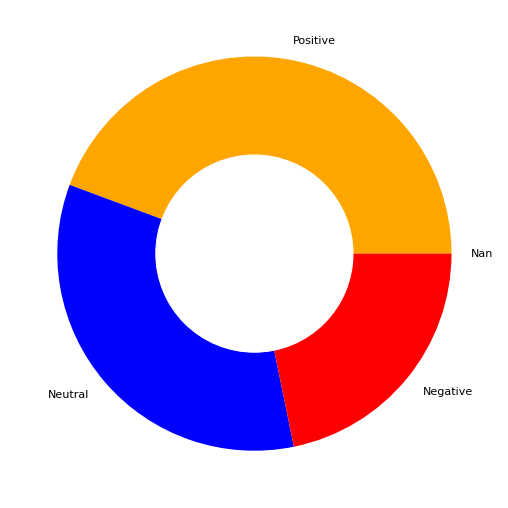

In [65]:
plt.figure(figsize=(13, 8), dpi=80)

# Chama a função 'count_values_in_column' para contar os valores da coluna "category" do dataframe
pichart = count_values_in_column(df, "category")

# Define os rótulos para cada categoria do gráfico de pizza
names = ["Positive", "Neutral", "Negative", "Nan"]

# Extrai os percentuais da variável 'pichart', que contém as contagens relativas
size = pichart["Percentage"]

# Cria um círculo branco no centro do gráfico de pizza para dar o efeito de "donut"
my_circle = plt.Circle((0, 0), 0.5, color="white")

# Gera o gráfico de pizza com as porcentagens e as cores definidas
plt.pie(size, labels=names, colors=["orange", "blue", "red", "green"])

# Adiciona o círculo branco ao gráfico de pizza para criar o efeito de donut
p = plt.gcf()
p.gca().add_artist(my_circle)  # Adiciona o círculo à figura

plt.show()

In [66]:
def create_wordcloud(text, path):
    """
    Gera e salva uma nuvem de palavras (Word Cloud) a partir de um texto fornecido.

    Parâmetros:
    -----------
    text : str
        O texto de entrada para gerar a nuvem de palavras. As palavras mais frequentes no texto serão destacadas.

    path : str
        O caminho do arquivo onde a imagem da nuvem de palavras será salva.

    Funcionamento:
    --------------
    1. Define uma lista de palavras de parada (`stopwords`) utilizando o conjunto `STOPWORDS` da biblioteca WordCloud.
       Essas palavras comuns (como "o", "e", "de") serão excluídas da nuvem.

    2. Configura a nuvem de palavras com as seguintes propriedades:
       - `background_color="white"`: Define o fundo da nuvem de palavras como branco.
       - `max_words=3000`: Limita a nuvem a um máximo de 3000 palavras.
       - `stopwords=stopwords`: Exclui as palavras de parada definidas anteriormente.
       - `random_state=42`: Define um valor fixo para o gerador de números aleatórios, garantindo que o layout da nuvem de palavras seja reproduzível.
       - `width=900` e `height=500`: Define as dimensões da imagem da nuvem de palavras.
       - `repeat=True`: Permite que palavras se repitam na imagem, se necessário.

    3. Converte o texto de entrada para string e gera a nuvem de palavras com base nesse texto.

    4. Salva a imagem gerada no caminho especificado (`path`) usando o método `to_file()`.

    5. Exibe uma mensagem de sucesso após salvar a imagem.

    6. Carrega e exibe a imagem da nuvem de palavras usando a função `display()` e o módulo `Image` da biblioteca `PIL`.

    Retorna:
    --------
    Não há retorno explícito, mas a imagem da nuvem de palavras será exibida e salva no local especificado.

    Exemplo de uso:
    ---------------
    create_wordcloud("Aqui vai o seu texto", "nuvem_palavras.png")
    """
    stopwords = set(STOPWORDS)
    wc = WordCloud(
        background_color="white",
        max_words=3000,
        stopwords=stopwords,
        random_state=42,
        width=900,
        height=500,
        repeat=True,
    )
    wc.generate(str(text))
    wc.to_file(path)
    print("Word Cloud Saved Successfully")
    path = path
    display(Image.open(path))

## Nuvem de Palavras para todos os tweets

Word Cloud Saved Successfully


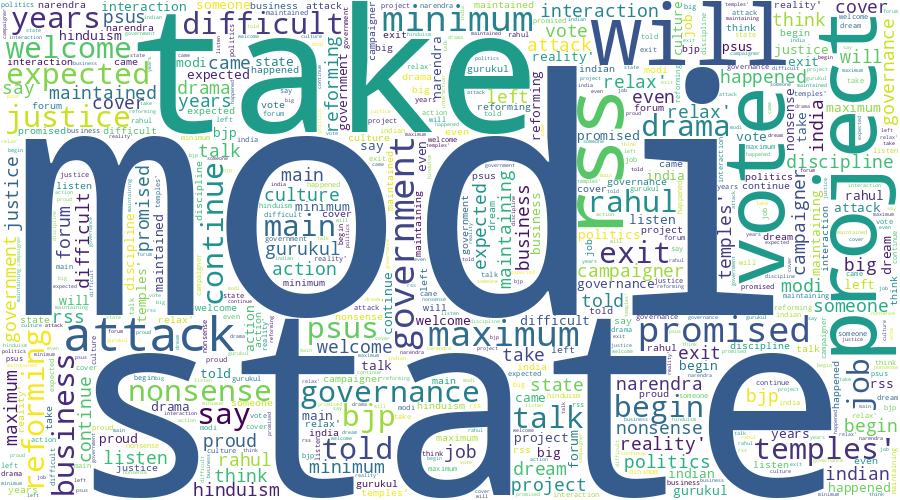

<Figure size 1200x640 with 0 Axes>

In [67]:
plt.figure(figsize=(15, 8), dpi=80)
create_wordcloud(df["clean_text"].values, "resources/all.png")

## Nuvem de Palavras dos Tweets Positivos

Word Cloud Saved Successfully


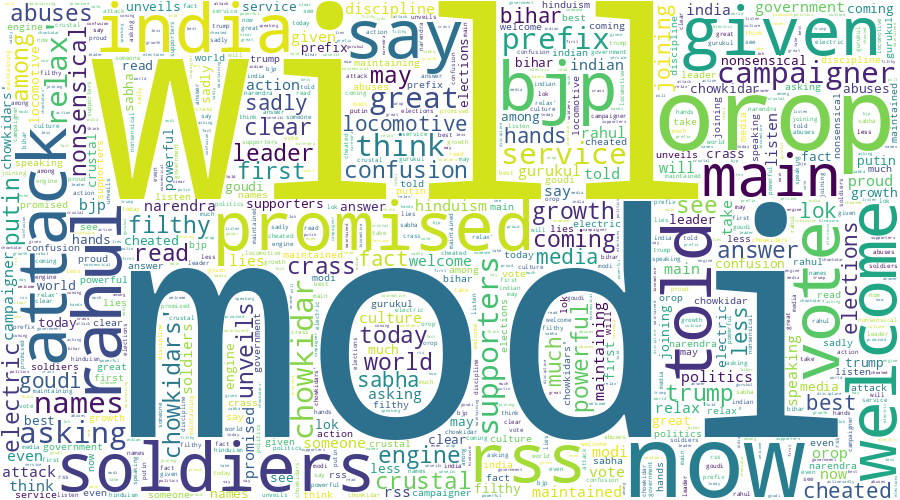

<Figure size 1200x640 with 0 Axes>

In [68]:
plt.figure(figsize=(15, 8), dpi=80)
create_wordcloud(df_positive["clean_text"].values, "resources/positive.png")

## Nuvem de Palavras dos Tweets Negativos

Word Cloud Saved Successfully


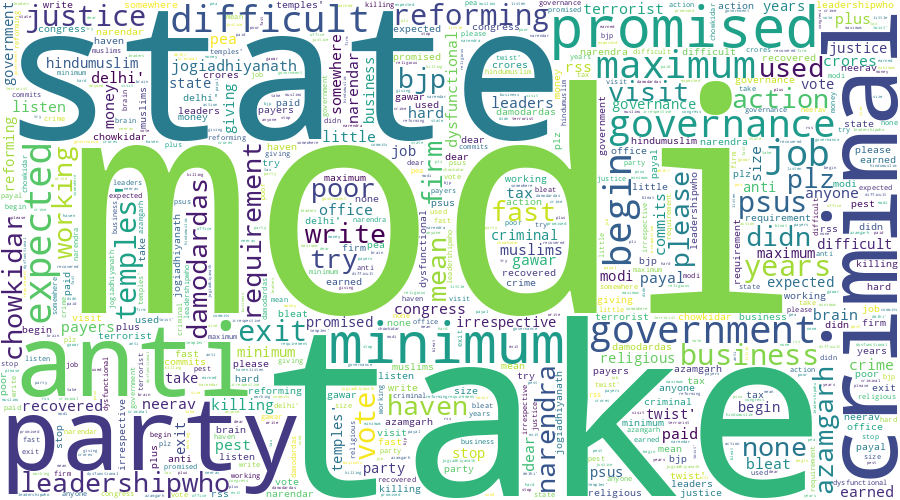

<Figure size 1200x640 with 0 Axes>

In [69]:
plt.figure(figsize=(15, 8), dpi=80)
create_wordcloud(df_negative["clean_text"].values, "resources/negative.png")

## Nuvem de Palavras dos Tweets Neutros

Word Cloud Saved Successfully


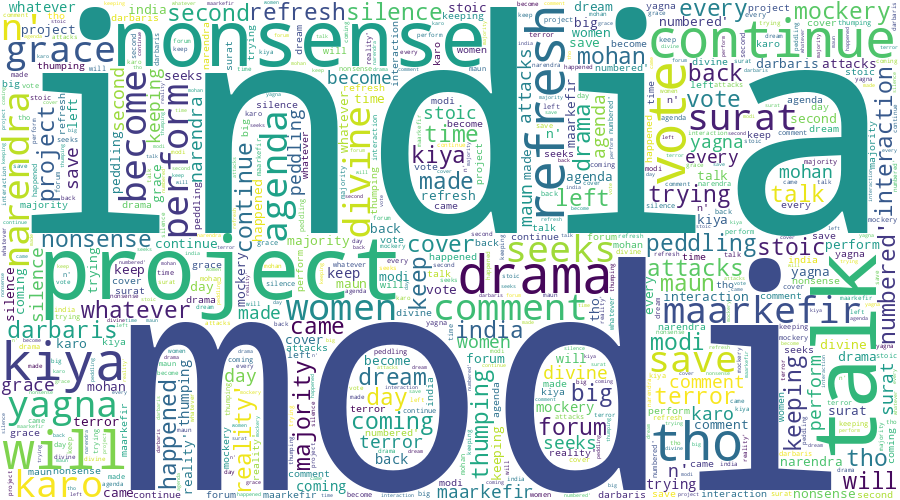

<Figure size 1200x640 with 0 Axes>

In [70]:
plt.figure(figsize=(15, 8), dpi=80)
create_wordcloud(df_neutral["clean_text"].values, "resources/neutral.png")

# 3. **Pré-processamento dos Dados**
- **Stemming**: Redução das palavras às suas raízes utilizando o algoritmo Porter Stemmer.
- **Remoção de Stopwords**: Excluindo palavras irrelevantes para análise de sentimentos.
- **Corpo de Texto (Corpus)**:
  - Criação de uma lista processada de sentenças (corpus).
  - Exportação e reimportação do corpus processado para facilitar o acesso.

In [71]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [72]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

ps = PorterStemmer()
stop_words = set(stopwords.words("english"))

corpus = []
palavras = []

# Obtendo a lista de textos de forma eficiente
clean_texts = df["clean_text"].values

# Loop de pré-processamento
for text in clean_texts:
    # Removendo caracteres que não sejam letras e convertendo para minúsculas
    analise = re.sub("[^a-zA-Z]", " ", str(text)).lower()

    # Dividindo o texto em palavras e aplicando o stemming
    palavras_stemmed = [
        ps.stem(palavra)
        for palavra in analise.split()
        if palavra not in stop_words
    ]

    # Adicionando o texto processado e as palavras ao corpus e à lista de palavras
    corpus.append(" ".join(palavras_stemmed))
    palavras.append(palavras_stemmed)

In [73]:
# Amostra do corpus
corpus[1:10]

['talk nonsens continu drama vote modi',
 'say vote modi welcom bjp told rahul main campaign modi think modi relax',
 'ask support prefix chowkidar name modi great servic confus read crustal clear crass filthi nonsens see abus come chowkidar',
 'answer among power world leader today trump putin modi may',
 'kiya tho refresh maarkefir comment karo',
 'surat women perform yagna seek divin grace narendra modi becom',
 'come cabinet scholar like modi smriti hema time introspect',
 'upcom elect india saga go import pair look current modi lead govt elect deal brexit combin weekli look juici bear imho',
 'gandhi gay modi']

In [74]:
print("Tamanho do corpus:", len(corpus))

Tamanho do corpus: 162980


In [75]:
# Colocando o texto processado no nosso dataset
df["clean_text"] = corpus

# Dropando valores nulos e resetando o index
df = df.dropna()
df = df.reset_index()

# Checando por valores nulos depois da atualização do corpus
df.isna().sum()

,0
index,0
clean_text,0
category,0


In [76]:
# Exportando as sentenças stemmed
df[["clean_text", "category"]].to_csv("stemmed.csv", index=False)

# Carregando as sentenças stemmed
df_stemmed = pd.read_csv("stemmed.csv")

# Extraindo o corpus
corpus = df_stemmed["clean_text"]

## **Vetorização com TF-IDF**
- **TF-IDF Vectorizer**:
  - Extração de recursos textuais usando n-grams (1 a 3).
  - Limitação a 5000 características mais relevantes.
- Criação de um dataframe com os vetores TF-IDF e categorias.

In [77]:
# Aplicando vetorização TF-IDF
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
X_tfidf = tfidf.fit_transform(df["clean_text"]).toarray()

In [78]:
# Variável independente
X = df_stemmed["clean_text"]

# Variável dependente
Y = df_stemmed["category"]

In [79]:
df_tfidf = pd.DataFrame(X_tfidf, columns=tfidf.get_feature_names_out())
df_tfidf["output"] = Y
df_tfidf.head()

,aadhaar,aadhar,aaj,aam,aap,aayega,aayog,abdullah,abe,abhi,...,youngster,your,youth,youtub,youv,yr,yr modi,zee,zero,output
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [80]:
df["clean_text"] = df["clean_text"].dropna()
df["clean_text"]

,clean_text
0,modi promis minimum govern maximum govern expe...
1,talk nonsens continu drama vote modi
2,say vote modi welcom bjp told rahul main campa...
3,ask support prefix chowkidar name modi great s...
4,answer among power world leader today trump pu...
...,...
162968,crore paid neerav modi recov congress leader h...
162969,dear rss terrorist payal gawar modi kill plu m...
162970,cover interact forum left
162971,big project came india modi dream project happ...


## **Tokenização e Sequenciamento**
- **Tokenização**: Conversão de texto em sequências numéricas.
- **Preenchimento (`pad_sequences`)**:
  - Ajuste do comprimento das sequências para um tamanho fixo (100).

In [81]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["clean_text"])
df["clean_text"] = tokenizer.texts_to_sequences(list(df["clean_text"]))
df["clean_text"]

,clean_text
0,"[1, 54, 693, 26, 1522, 26, 269, 884, 1089, 56,..."
1,"[86, 980, 371, 721, 8, 1]"
2,"[10, 8, 1, 760, 3, 458, 23, 388, 109, 1, 37, 1..."
3,"[43, 25, 2910, 52, 117, 1, 82, 937, 1097, 190,..."
4,"[234, 784, 31, 72, 40, 64, 781, 2993, 1, 91]"
...,...
162968,"[105, 524, 2094, 1, 1281, 6, 40, 276, 678, 46,..."
162969,"[272, 315, 215, 9265, 7253, 1, 235, 1317, 140,..."
162970,"[916, 1168, 4109, 357]"
162971,"[149, 325, 311, 2, 1, 479, 325, 103, 519]"


In [82]:
df["category"].mask(df["category"] == "negative", -1, inplace=True)
df["category"].mask(df["category"] == "normal", 0, inplace=True)
df["category"].mask(df["category"] == "positive", 1, inplace=True)
df["category"]

,category
0,-1.0
1,0.0
2,1.0
3,1.0
4,1.0
...,...
162968,-1.0
162969,-1.0
162970,0.0
162971,0.0


## **Divisão de Dados**
- Separação dos dados em conjuntos de treino (60%), conjunto de testes (20%) e conjunto de validação (20%).

In [83]:
from sklearn.model_selection import train_test_split

# Divisão inicial entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    df["clean_text"], df["category"], test_size=0.2, random_state=42
)

# Divisão adicional no conjunto de treino para criar o conjunto de validação
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42  # 0.25 * 0.8 = 0.2 do total
)

# Exibindo os tamanhos dos conjuntos
print(f"Tamanho do treino: {len(X_train)}")
print(f"Tamanho do validação: {len(X_val)}")
print(f"Tamanho do teste: {len(X_test)}")

Tamanho do treino: 97783
Tamanho do validação: 32595
Tamanho do teste: 32595


In [84]:
# Aplicando padding aos conjuntos de treino, validação e teste
X_train = pad_sequences(X_train, maxlen=100, dtype="float32")
X_val = pad_sequences(X_val, maxlen=100, dtype="float32")
X_test = pad_sequences(X_test, maxlen=100, dtype="float32")

# Calculando o tamanho do vocabulário
vocab_size = len(tokenizer.index_word)

# Exibindo informações
print(f"Tamanho do vocabulário: {vocab_size}")
print(f"Tamanho do treino (padded): {X_train.shape}")
print(f"Tamanho do validação (padded): {X_val.shape}")
print(f"Tamanho do teste (padded): {X_test.shape}")

Tamanho do vocabulário: 82091
Tamanho do treino (padded): (97783, 100)
Tamanho do validação (padded): (32595, 100)
Tamanho do teste (padded): (32595, 100)


In [85]:
# Conversão dos conjuntos de treino, validação e teste para o tipo float32
X_train = np.asarray(X_train, dtype=np.float32)
X_val = np.asarray(X_val, dtype=np.float32)
X_test = np.asarray(X_test, dtype=np.float32)

# Conversão das labels e reformatação para um vetor coluna
y_train = np.asarray(y_train, dtype=np.float32).reshape(-1, 1)
y_val = np.asarray(y_val, dtype=np.float32).reshape(-1, 1)
y_test = np.asarray(y_test, dtype=np.float32).reshape(-1, 1)

# Tamanho de cada um dos arrays
print(f"Tamanho do treino: {X_train.shape}, {y_train.shape}")
print(f"Tamanho do teste: {X_test.shape}, {y_test.shape}")
print(f"Tamanho da validação: {X_val.shape}, {y_val.shape}")

Tamanho do treino: (97783, 100), (97783, 1)
Tamanho do teste: (32595, 100), (32595, 1)
Tamanho da validação: (32595, 100), (32595, 1)


# 4. **Modelos Utilizados**

## Rede Neural 1: Classificação Binária
- Arquitetura:
  - Camada Embedding para mapeamento semântico.
  - Camada LSTM bidirecional para capturar dependências temporais.
  - Camada densa e `Dropout` para evitar overfitting.
- **Função de Perda**: `binary_crossentropy`.
- **Métrica**: Acurácia.
- Treinamento com `EarlyStopping` para evitar overfitting.

In [86]:
def build_neural_net_binary(vocab_size, input_length):
    model = Sequential(name="Bidirectional_LSTM_Binary_Classifier")
    model.add(Embedding(vocab_size, output_dim=50, input_length=input_length))
    model.add(Bidirectional(LSTM(100)))
    model.add(Flatten())
    model.add(Dense(250, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))  # Binary classification
    return model

In [87]:
from keras.metrics import Precision, Recall, AUC

def compile_model(model, loss, optimizer="adam"):
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=["accuracy", Precision(name="precision"), Recall(name="recall"), AUC(name="auc")]
)

## Rede Neural 2: Classificação Multiclasse
- Arquitetura:
  - Similar ao Modelo 1, com ajuste na camada de saída para classificação multiclasse.
- **Função de Perda**: `categorical_crossentropy`.
- **Métrica**: Acurácia.

In [88]:
def build_neural_net_multiclass(vocab_size, input_length):
    model = Sequential(name="LSTM_Multiclass_Classifier")
    model.add(Embedding(vocab_size, output_dim=100, input_length=input_length))
    model.add(LSTM(100))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(3, activation="softmax"))  # Multiclass classification
    return model

## KNN com GridSearch

In [89]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

def train_knn(X_train, y_train):
    print("\nTreinando o modelo KNN...")
    knn = KNeighborsClassifier()

    # Grid Search para hiperparâmetros
    param_grid_knn = {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }
    grid_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, scoring='accuracy', cv=5)

    # Treinamento do modelo
    grid_knn.fit(X_train, y_train)
    print(f"Melhores hiperparâmetros para KNN: {grid_knn.best_params_}")
    print(f"Melhor acurácia para KNN (cross-validation): {grid_knn.best_score_:.4f}")

    return grid_knn.best_estimator_

## Arvore de Decisão com Grid Search

In [90]:
from sklearn.tree import DecisionTreeClassifier

def train_decision_tree(X_train, y_train):
    print("\nTreinando o modelo de Árvore de Decisão...")
    dt = DecisionTreeClassifier(random_state=42)

    # Grid Search para hiperparâmetros
    param_grid_dt = {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    grid_dt = GridSearchCV(estimator=dt, param_grid=param_grid_dt, scoring='accuracy', cv=5)

## XGBoost


In [91]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

def train_xgboost(X_train, y_train):
    print("\nTreinando o modelo XGBoost...")
    # Definir o modelo com os hiperparâmetros escolhidos
    model = xgb.XGBClassifier(
        n_estimators=100,         # Número de árvores
        max_depth=3,              # Profundidade máxima das árvores
        learning_rate=0.1,        # Taxa de aprendizado
        subsample=0.8,            # Proporção de amostras usadas para treinar cada árvore
        colsample_bytree=0.8,     # Proporção de colunas usadas para cada árvore
        objective='multi:softmax',  # Função de perda para classificação multiclasse
        num_class=3
    )

    # Corrigir rótulos se necessário e treinar o modelo
    y_train_corrected = correct_negative_values(y_train)
    model.fit(X_train, y_train_corrected)

    return model

def correct_negative_values(y):
    if np.any(y < 0):
        # Corrigir valores negativos (por exemplo, transformando para 0, 1, 2)
        y = np.clip(y, 0, None)
    return y

In [94]:
print(X_train.shape)
print(y_train.shape)

(97783, 100)
(97783, 1)


# 5. **Relatório final dos modelos utilizados**

In [ ]:
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

# Configuração inicial
vocab_size = len(tokenizer.index_word) + 1
input_length = 100
early_stop = EarlyStopping(monitor="val_loss", patience=5, verbose=True)

# Construção dos modelos
model_1 = build_neural_net_binary(vocab_size, input_length)
compile_model(model_1, loss="binary_crossentropy")
model_1.summary()

model_2 = build_neural_net_multiclass(vocab_size, input_length)
compile_model(model_2, loss="categorical_crossentropy")
model_2.summary()

# Treinamento do modelo 1
history_1 = model_1.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
)

Model: "Bidirectional_LSTM_Binary_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 100, 50)           4104600   
                                                                 
 bidirectional_4 (Bidirecti  (None, 200)               120800    
 onal)                                                           
                                                                 
 flatten_4 (Flatten)         (None, 200)               0         
                                                                 
 dense_16 (Dense)            (None, 250)               50250     
                                                                 
 dropout_4 (Dropout)         (None, 250)               0         
                                                                 
 dense_17 (Dense)            (None, 1)                 251       
                              

In [ ]:
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)
y_val = to_categorical(y_val, 3)

# Treinamento do modelo 2
history_2 = model_2.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
)

In [ ]:
best_knn = train_knn(X_train, y_train)
best_dt = train_decision_tree(X_train, y_train)
xgboost_model = train_xgboost(X_train, y_train)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def evaluate_neural_models(model, X_val, y_val, model_name):
    results = model.evaluate(X_val, y_val, verbose=0)
    metrics = dict(zip(model.metrics_names, results))
    print(f"\nAvaliação do {model_name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    return metrics

def evaluate_model(model, X_val, y_val, model_name):
    y_pred = model.predict(X_val)
    print(f"\nAvaliação do {model_name}:")

    # Métricas detalhadas
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, average="weighted")
    rec = recall_score(y_val, y_pred, average="weighted")
    f1 = f1_score(y_val, y_pred, average="weighted")

    # Relatórios
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))

    # Matriz de confusão
    print("\nMatriz de Confusão:")
    print(confusion_matrix(y_val, y_pred))

In [ ]:
metrics_1 = evaluate_model(model_1, X_val, y_val, "Bidirectional LSTM Binary Classifier")
metrics_2 = evaluate_model(model_2, X_val, y_val, "LSTM Multiclass Classifier")

## 11. **Funções para Predição**
- **Decodificação de Sentimento**:
  - Mapeamento de probabilidades para categorias (`positive`, `neutral`, `negative`).
- **Predição em Tempo Real**:
  - Função personalizada para processar e prever sentimentos de textos novos.

In [ ]:
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SEQUENCE_LENGTH = 300


def decode_sentiment(score):
    """
    Função que recebe uma pontuação de sentimento (score) e retorna o sentimento
    correspondente e a confiança (probabilidade) dessa previsão.

    A função utiliza o índice da maior pontuação no vetor `score` para determinar
    o sentimento e retorna também a probabilidade dessa previsão.

    Parâmetros:
    - score: Vetor contendo as pontuações para cada sentimento (neutro, positivo, negativo).
             Cada valor representa a probabilidade do sentimento correspondente:
             0 -> Neutro, 1 -> Positivo, 2 -> Negativo.

    Retorno:
    - sentimento: O sentimento identificado (NEUTRAL, POSITIVE ou NEGATIVE).
    - confiança: O valor da maior probabilidade (a confiança do modelo na previsão).
    """
    sentimentos = {
        0: NEUTRAL,
        1: POSITIVE,
        2: NEGATIVE,
    }

    # Retorna o sentimento correspondente ao índice da maior pontuação e a confiança
    return sentimentos.get(np.argmax(score)), np.max(score)

In [ ]:
def predict(clean_text):
    start_at = time.time()

    # Tokenizando o texto limpo
    x_test = pad_sequences(
        tokenizer.texts_to_sequences([clean_text]), maxlen=SEQUENCE_LENGTH
    )

    # Fazendo as predições
    score = model.predict([x_test])[0]
    print(f"Probabilidade de ser neutro: {score[0]}")
    print(f"Probabilidade de ser positivo: {score[1]}")
    print(f"Probabilidade de ser negativo: {score[2]}")

    # Decodificando o sentimento
    label, max_score = decode_sentiment(score)

    return {
        "label": label,
        "score": float(max_score),
        "elapsed_time": time.time() - start_at,
    }

In [ ]:
predict("I love the music")

In [ ]:
predict("I have nothing to lose")


In [ ]:
predict("Experience has been bad")